In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
import vaex
import matplotlib.dates as mdates

import sys

sys.path.append("../../")
sys.path.append("../")

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.data import get_events, get_sections, load_df, export_dataframe_to_latex

import warnings

warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = "../../thesis/assets/generated/"
latex_tex_path = "../../thesis/tex/generated/"

In [2]:
%%time

filename = "../models/2020/boat_data_50ms.csv"

df = vaex.from_csv(filename).to_pandas_df()
df["timestamp"] = pd.DatetimeIndex(df["timestamp"])
df = df.set_index("timestamp", drop=True)
df = df.interpolate(method="time", limit=200, limit_area="inside", limit_direction="both")
df["t"] = df.index.to_series().diff().median().total_seconds() * np.arange(len(df.index))

display(df.describe())

,Battery Pack Voltage (MCS),Battery 1 Pack Voltage (MCB),Battery 2 Pack Voltage (MCB),Battery 1 Pack Voltage (MCC),Battery 2 Pack Voltage (MCC),Battery 3 Pack Voltage (MCC),Battery 4 Pack Voltage (MCC),Battery 1 Cell Voltage (MSC),Battery 2 Cell Voltage (MSC),Battery 3 Cell Voltage (MSC),...,MPPT 4 Input Power,MPPTs Input Power,Battery Input Current Sensor State == STATE_RUNNING,Battery Output Current Sensor State == STATE_RUNNING,Battery Current,Air Temperature,Solar POA,Wind Speed,Wind Direction,t
count,2.418035e+06,2884260.0,2884260.0,1.984907e+06,1.745539e+06,1.986097e+06,1.985191e+06,2.418207e+06,2.418616e+06,2.418616e+06,...,1.916006e+06,1.726439e+06,7.018608e+06,7.018608e+06,1.271979e+06,7.014880e+06,7.014880e+06,7.014880e+06,7.014880e+06,7.018608e+06
mean,5.143168e+02,0.0,0.0,3.935317e+01,3.978243e+01,3.931856e+01,3.932965e+01,1.310904e+01,1.279192e+01,1.281832e+01,...,9.746299e+01,4.208514e+02,9.698752e-01,5.212451e-01,-6.912923e-01,2.579579e+01,2.204424e+02,1.915383e+00,1.536831e+02,1.754652e+05
std,4.039152e+01,0.0,0.0,3.319237e+00,3.306856e+00,3.290247e+00,3.272193e+00,8.615769e-01,1.156431e+00,8.180696e-01,...,7.685581e+01,3.102652e+02,1.709306e-01,4.995485e-01,1.422455e+01,2.895196e+00,3.032208e+02,9.237959e-01,8.623582e+01,1.013049e+05
min,3.410000e+02,0.0,0.0,2.621057e+01,9.638570e-01,2.615266e+01,2.601025e+01,1.043000e+01,6.320000e+00,8.730000e+00,...,-1.504736e-01,-8.236751e-01,0.000000e+00,0.000000e+00,-3.224000e+01,2.230000e+01,0.000000e+00,2.000000e-01,0.000000e+00,0.000000e+00
25%,4.960000e+02,0.0,0.0,3.781241e+01,3.819905e+01,3.783128e+01,3.783619e+01,1.269000e+01,1.234000e+01,1.230000e+01,...,3.906558e+01,1.746842e+02,1.000000e+00,0.000000e+00,-3.000000e+00,2.350000e+01,0.000000e+00,1.200000e+00,8.604983e+01,8.773259e+04
50%,5.080000e+02,0.0,0.0,3.885203e+01,3.905033e+01,3.886901e+01,3.886305e+01,1.293000e+01,1.262000e+01,1.292000e+01,...,7.122326e+01,3.132266e+02,1.000000e+00,1.000000e+00,0.000000e+00,2.470000e+01,4.505075e+01,1.800000e+00,1.340000e+02,1.754652e+05
75%,5.223000e+02,0.0,0.0,3.999149e+01,4.023867e+01,4.002412e+01,4.002370e+01,1.332000e+01,1.300500e+01,1.325000e+01,...,1.618284e+02,6.829396e+02,1.000000e+00,1.000000e+00,0.000000e+00,2.764940e+01,3.924840e+02,2.400000e+00,2.186910e+02,2.631978e+05
max,6.510000e+02,0.0,0.0,5.811414e+01,5.121497e+01,5.546066e+01,7.106486e+01,1.711000e+01,1.618000e+01,1.734000e+01,...,3.400355e+02,1.432469e+03,1.000000e+00,1.000000e+00,1.519000e+02,3.290000e+01,1.025575e+03,4.100000e+00,3.600000e+02,3.509304e+05


CPU times: user 1min 37s, sys: 6.67 s, total: 1min 44s
Wall time: 1min 42s


In [11]:
df.columns

Index(['Battery Pack Voltage (MCS)', 'Battery 1 Pack Voltage (MCB)',
       'Battery 2 Pack Voltage (MCB)', 'Battery 1 Pack Voltage (MCC)',
       'Battery 2 Pack Voltage (MCC)', 'Battery 3 Pack Voltage (MCC)',
       'Battery 4 Pack Voltage (MCC)', 'Battery 1 Cell Voltage (MSC)',
       'Battery 2 Cell Voltage (MSC)', 'Battery 3 Cell Voltage (MSC)',
       'Battery Input Current Sensor State', 'Battery Input Current',
       'Battery Output Current Sensor State', 'Battery Output Current',
       'ESC State', 'ESC Duty Cycle (MAM)', 'ESC Duty Cycle (MSWI)',
       'ESC Ramp (MAM)', 'ESC Ramp (MSWI)', 'ESC Motor State (MSWI)',
       'ESC Boat On (MSWI)', 'ESC Duty Cycle (MIC)', 'ESC Ramp (MIC)',
       'ESC Motor State (MIC)', 'ESC Boat On (MIC)', 'Motor Angular Speed',
       'MPPT 1 Input Voltage', 'MPPT 2 Input Voltage', 'MPPT 3 Input Voltage',
       'MPPT 4 Input Voltage', 'MPPT 1 Output Voltage',
       'MPPT 2 Output Voltage', 'MPPT 3 Output Voltage',
       'MPPT 4 Output Volta

In [12]:
generation_cols = [
    'Solar POA',
    *[f'MPPT {i} Duty Cycle' for i in range(1, 5)],
    *[f'MPPT {i} Input Current' for i in range(1, 5)],
    *[f'MPPT {i} Input Voltage' for i in range(1, 5)],
    *[f'MPPT {i} Output Voltage' for i in range(1, 5)],
]
propulsive_cols = ["ESC Duty Cycle", "Motor Angular Speed"]
battery_cols = ["Battery Pack Voltage", "Battery Current", "Battery Input Current", "Battery Output Current"]

display(generation_cols)
display(propulsive_cols)
display(battery_cols)

['Solar POA',
 'MPPT 1 Duty Cycle',
 'MPPT 2 Duty Cycle',
 'MPPT 3 Duty Cycle',
 'MPPT 4 Duty Cycle',
 'MPPT 1 Input Current',
 'MPPT 2 Input Current',
 'MPPT 3 Input Current',
 'MPPT 4 Input Current',
 'MPPT 1 Input Voltage',
 'MPPT 2 Input Voltage',
 'MPPT 3 Input Voltage',
 'MPPT 4 Input Voltage',
 'MPPT 1 Output Voltage',
 'MPPT 2 Output Voltage',
 'MPPT 3 Output Voltage',
 'MPPT 4 Output Voltage']

['ESC Duty Cycle', 'Motor Angular Speed']

['Battery Pack Voltage',
 'Battery Current',
 'Battery Input Current',
 'Battery Output Current']

# Generation signals

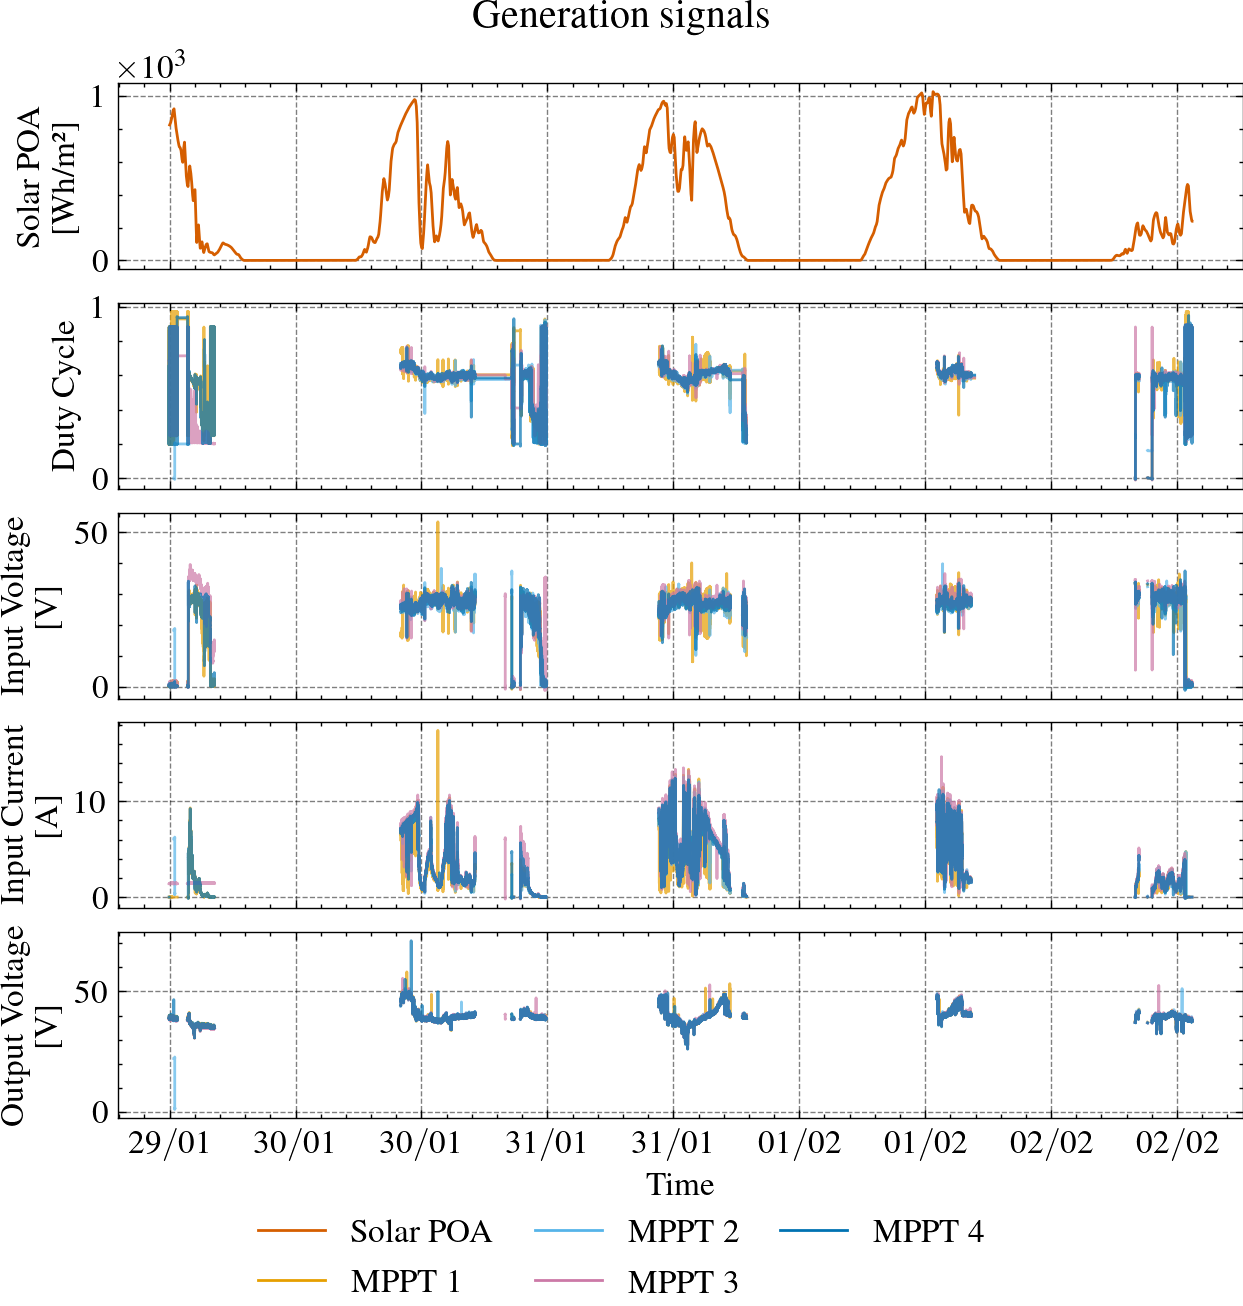

In [13]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=figsize(subplots=(0.3*5,1)))

ax[0].plot(df.index, df["Solar POA"], linestyle='solid', label="Solar POA", color='C4')
ax[0].set_ylabel("Solar POA\n[Wh/m²]")

for i in range(1,5):
    ax[1].plot(df.index, df[f"MPPT {i} Duty Cycle"], linestyle='solid', alpha=0.7)
ax[1].set_ylabel("Duty Cycle")

for i in range(1,5):
    ax[2].plot(df.index, df[f"MPPT {i} Input Voltage"], linestyle='solid', alpha=0.7)
ax[2].set_ylabel("Input Voltage\n[V]")

for i in range(1,5):
    ax[3].plot(df.index, df[f"MPPT {i} Input Current"], linestyle='solid', alpha=0.7)
ax[3].set_ylabel("Input Current\n[A]")

for i in range(1,5):
    ax[4].plot(df.index, df[f"MPPT {i} Output Voltage"], linestyle='solid', alpha=0.7)
ax[4].set_ylabel("Output Voltage\n[V]")

ax[-1].xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
ax[-1].set_xlabel("Time")

for i in range(1,5):
    ax[0].plot(np.nan, np.nan, label=f"MPPT {i}", linestyle='solid')

fig_save_and_show(
    filename=f'{latex_img_path}/transformation_generation_signals.pdf',
    save_title="Sinais da geração",
    show_title="Generation signals",
    ncol=3,
    fig=fig,
)

# Propulsive signals

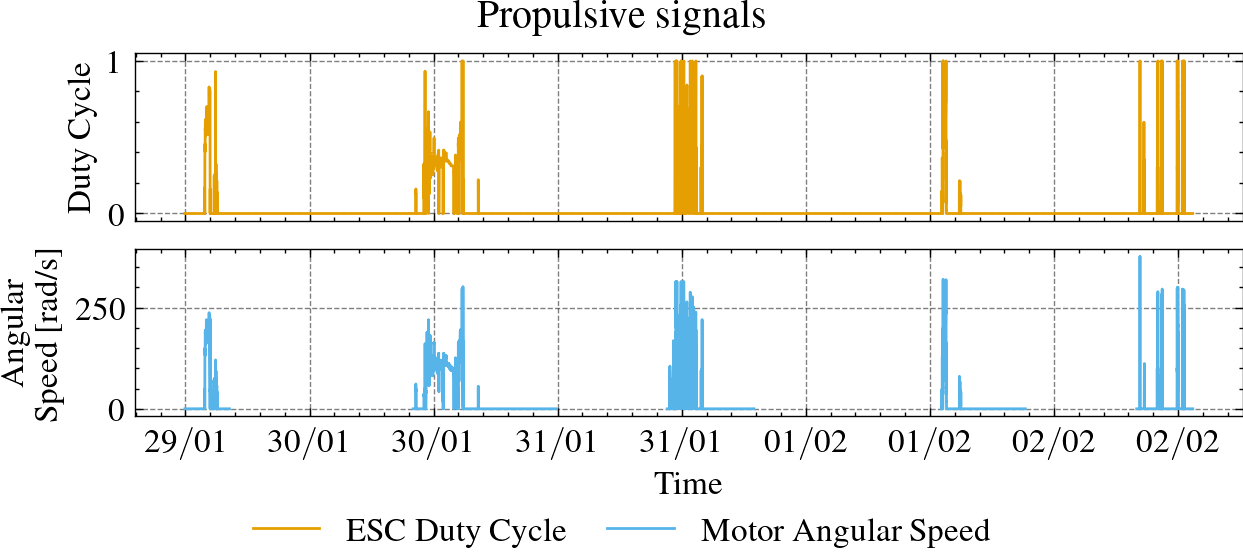

In [14]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=figsize(subplots=(0.3*2,1)))

ax[0].plot(df.index, df["ESC Duty Cycle"], color='C0', label="ESC Duty Cycle", linestyle='solid')
ax[0].set_ylabel("Duty Cycle")

ax[1].plot(df.index, df["Motor Angular Speed"], color='C1', label="Motor Angular Speed", linestyle='solid')
ax[1].set_ylabel("Angular\nSpeed [rad/s]")

ax[-1].xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
ax[-1].set_xlabel("Time")

fig_save_and_show(
    filename=f'{latex_img_path}/transformation_propulsive_signals.pdf',
    save_title="Sinais da propulsão",
    show_title="Propulsive signals",
    ncol=2,
    fig=fig,
)

# Battery signals

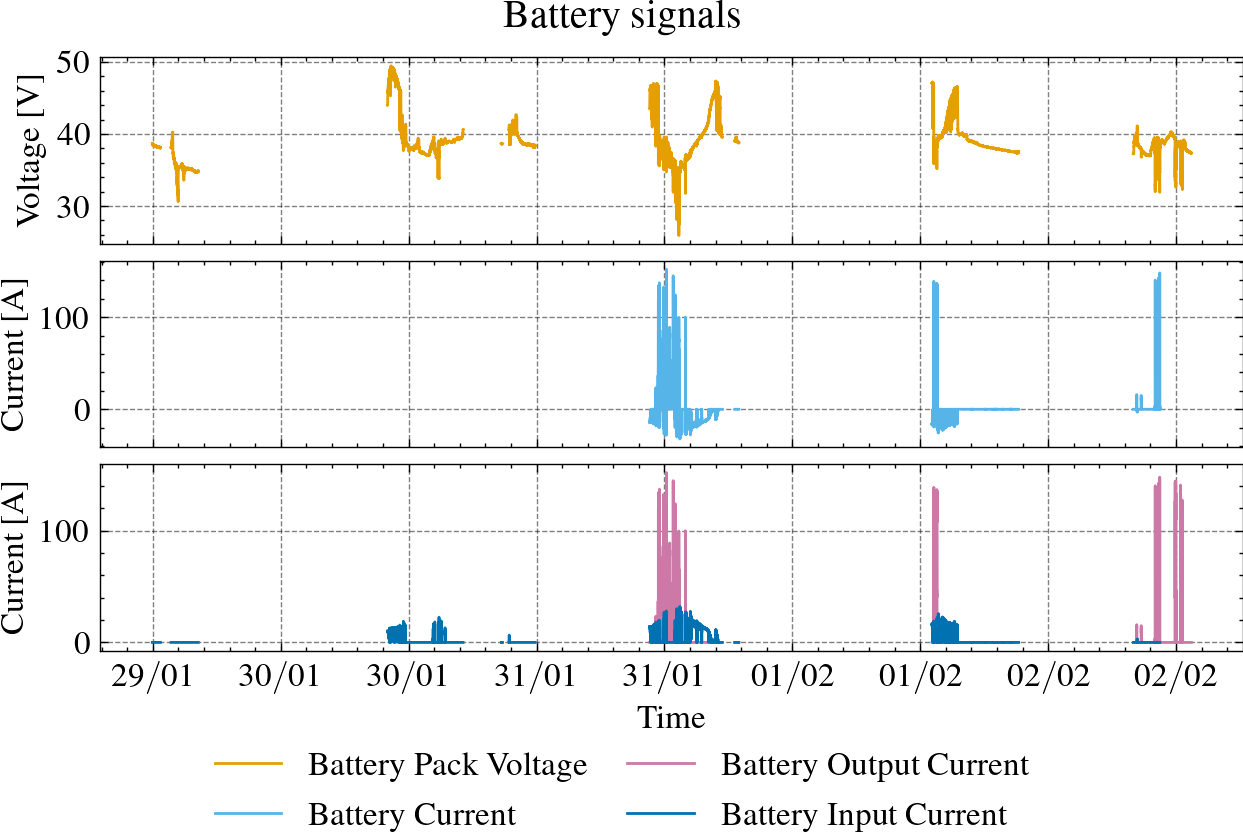

In [15]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=figsize(subplots=(0.3*3,1)))

ax[0].plot(df.index, df["Battery Pack Voltage"], color='C0', label="Battery Pack Voltage", linestyle='solid')
ax[0].set_ylabel("Voltage [V]")

ax[1].plot(df.index, df["Battery Current"], color='C1', label="Battery Current", linestyle='solid')
ax[1].set_ylabel("Current [A]")

ax[2].plot(df.index, df["Battery Output Current"], color='C2', label="Battery Output Current", linestyle='solid')
ax[2].plot(df.index, df["Battery Input Current"], color='C3', label="Battery Input Current", linestyle='solid')
ax[2].set_ylabel("Current [A]")

ax[-1].xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
ax[-1].set_xlabel("Time")

fig_save_and_show(
    filename=f'{latex_img_path}/transformation_battery_signals.pdf',
    save_title="Sinais da bateria",
    show_title="Battery signals",
    ncol=2,
    fig=fig,
)